# Capstone Project - The Battle of Neighborhoods

### Introduction
New York City is the most populous city in the United States, with an estimated 2018 population of over 8 million. The city is also one of the most diversified cities in the US. The city's population in 2010 was 44% white, 25.5% black, 12.7% Asian and 0.7% Native American. Among these different races, Asians is the fastest-growing one between 2000 and 2010. As the term "melting pot" described, approximately 37% of the city's population is foreign born. In New York, none of the single country or region of origin dominates.

The diverse culture leads to diverse food cuisines. In New York, you can find all kinds of authentic foreign restaurants, like French, Italian, Japanese, American, Chinese, etc.

In this project, we will list and visualize all parts of NYC which has great Chinese restaurants. The project can help visitors or newcomers to NYC to find their desired good Chinese restaurants. They can also decide which area of NYC they'd like to stay at for good Chinese food.

### Data 
The following data are needed for this project:
<ul>
<li> New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude.
    <ul>
        <li>Data source : https://cocl.us/new_york_dataset
        <li> Description : This data set provides the location of various neighborhoods of new york city.
     </ul>
<li> Chinese resturants in each neighborhood of new york city.
        <ul>
        <li>Data source : Fousquare API
        <li> Description : We will get all venues in each neighborhood and then filter them to get only Chinese restaurants.
     </ul>
<li> GeoSpace data
          <ul>
        <li>Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
        <li> Description : New york Borough boundaries for better map visulization.
</ul>

### Methodology
- Collect the new york city data from https://cocl.us/new_york_dataset
- Using FourSquare API to gather all venues for each neighborhood.
- Filter out all venues that are Chinese Resturants.
- Find rating , tips and like count for each Chinese Resturants using FourSquare API.
- Using rating for each resturant , we will sort that data.
- Visualize the Ranking of neighborhoods using Python folium library.

We will import the required libraries for python.

- pandas and numpy for handling data.
- request module for using FourSquare API.
- geopy to get co-ordinates of City of New York.
- folium to visualize the results on a map

In [ ]:
!conda install beautifulsoup4 -y -q
!conda install lxml -y -q
!conda install html5lib -y -q
!conda install -c conda-forge geopy --yes -q

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import os
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Libraries imported.


Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

We define a function to intract with FourSquare API and get top 100 venues within a radius of 500 metres for a given  latitude and longitude. Below function will return us the venue id , venue name and category.

In [4]:
def get_venues(lat,lng):
    
    #set variables
    radius=500
    LIMIT=100
    CLIENT_ID = 'LW3UGMYMUJVVNYECWZG23T3CTV01VKY4NLNDOBLQUTXSOHVU' # your Foursquare ID
    CLIENT_SECRET = 'BARAAPKHMIVSGG44OFVZCW2FRCDRMUHFNUX03IKWDUWV1UQT' # your Foursquare Secret
    VERSION = '20190829' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df
    

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id.
This will be used for ranking.

In [5]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'LW3UGMYMUJVVNYECWZG23T3CTV01VKY4NLNDOBLQUTXSOHVU' # your Foursquare ID
    CLIENT_SECRET = 'BARAAPKHMIVSGG44OFVZCW2FRCDRMUHFNUX03IKWDUWV1UQT' # your Foursquare Secret
    VERSION = '20190829' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [6]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

We will call the above funtion to get the new york city data.

In [7]:
# get new york data
new_york_data=get_new_york_data()

In [8]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [9]:
new_york_data.shape

(306, 4)

So there are total of 306 different Neighborhoods in New York

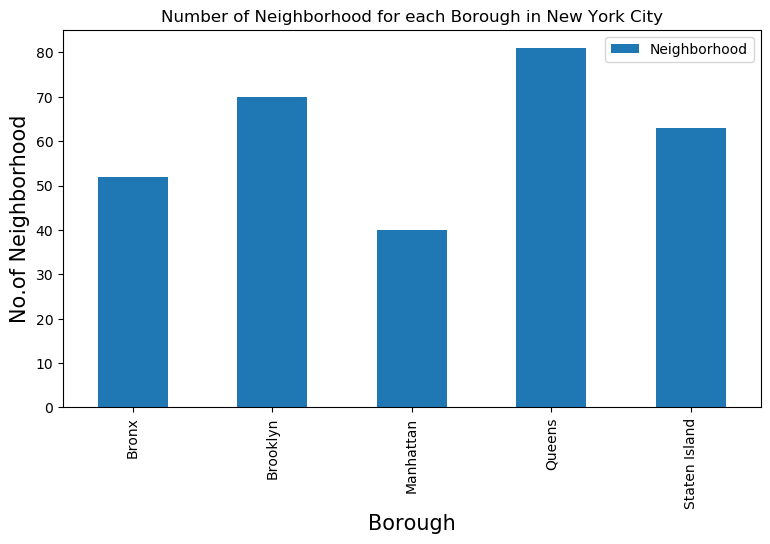

In [10]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Queens has highest number of neighborhoods

Now we will collect Chinese resturants for each Neighborhood

In [12]:
# prepare neighborhood list that contains chinese resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
chinese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    chinese_resturants=venues[venues['Category']=='Chinese Restaurant']   
    print('(',count,'/',len(new_york_data),')','Chinese Resturants in '+Neighborhood+', '+Borough+':'+str(len(chinese_resturants)))
    for resturant_detail in chinese_resturants.values.tolist():
        id, name , category=resturant_detail
        chinese_rest_ny = chinese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Chinese Resturants in Wakefield, Bronx:0
( 2 / 306 ) Chinese Resturants in Co-op City, Bronx:1
( 3 / 306 ) Chinese Resturants in Eastchester, Bronx:1
( 4 / 306 ) Chinese Resturants in Fieldston, Bronx:0
( 5 / 306 ) Chinese Resturants in Riverdale, Bronx:0
( 6 / 306 ) Chinese Resturants in Kingsbridge, Bronx:1
( 7 / 306 ) Chinese Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Chinese Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Chinese Resturants in Norwood, Bronx:3
( 10 / 306 ) Chinese Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Chinese Resturants in Baychester, Bronx:0
( 12 / 306 ) Chinese Resturants in Pelham Parkway, Bronx:1
( 13 / 306 ) Chinese Resturants in City Island, Bronx:0
( 14 / 306 ) Chinese Resturants in Bedford Park, Bronx:2
( 15 / 306 ) Chinese Resturants in University Heights, Bronx:0
( 16 / 306 ) Chinese Resturants in Morris Heights, Bronx:1
( 17 / 306 ) Chinese Resturants in Fordham, Bronx:3
( 18 / 306 ) Chinese Resturants in East Tremont, Bronx:

Now that we have got all the Chinese resturants in new york city , we will analyze it

In [13]:
chinese_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Co-op City,4c9d5f2654c8a1cd2e71834b,Guang Hui Chinese Restaurant
1,Bronx,Eastchester,4dabc3dc93a04642f09ccabd,Xing Lung Chinese Restaurant
2,Bronx,Kingsbridge,4ec2fa2f0aaf300b7fb29e5a,Golden Gate Express
3,Bronx,Norwood,4e41d2c4b61ca5ba3b1f9c6b,Ming Liang Kitchen
4,Bronx,Norwood,4e6aa73eaeb7c31e43294be9,Sing Fei Chinese Restaurant


In [14]:
chinese_rest_ny.shape

(224, 4)

We got 224 Chinese Resturants across New York City

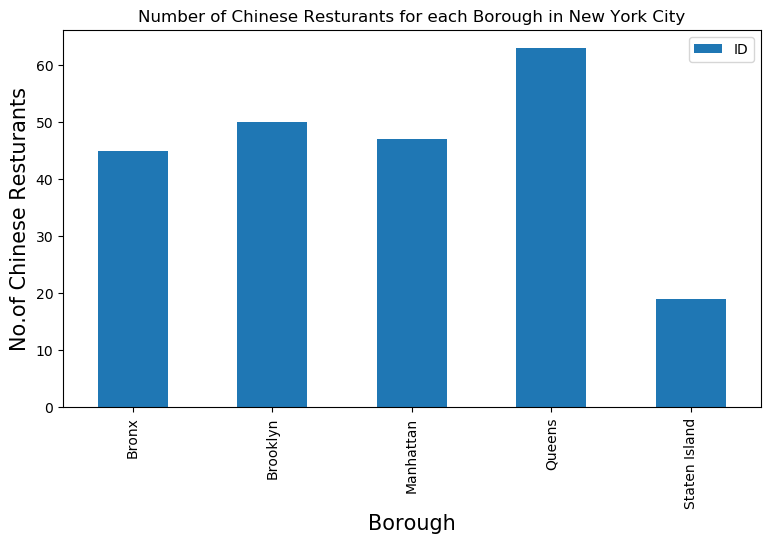

In [15]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Chinese Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Chinese Resturants', fontsize=15)
#giving a bar plot
chinese_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Queens has the largest number of Chinese resturants

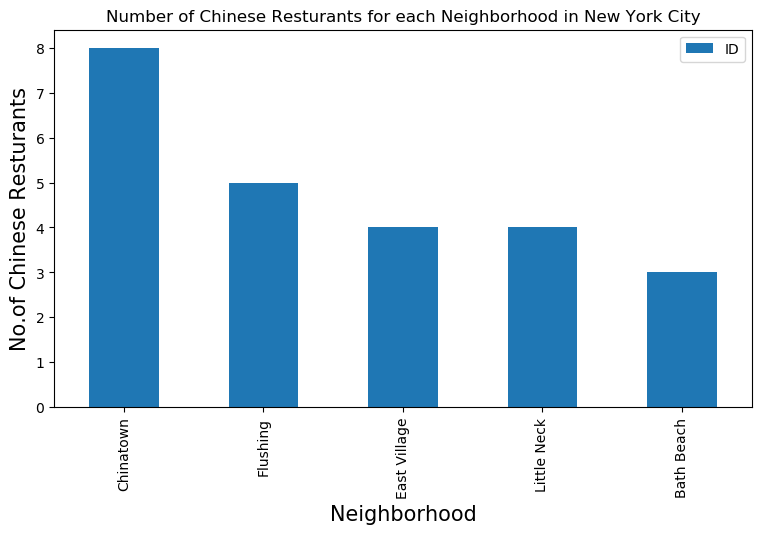

In [16]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Chinese Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Chinese Resturants', fontsize=15)
#giving a bar plot
chinese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [17]:
chinese_rest_ny[chinese_rest_ny['Neighborhood']=='Chinatown']

,Borough,Neighborhood,ID,Name
75,Manhattan,Chinatown,4db3374590a0843f295fb69b,Spicy Village
76,Manhattan,Chinatown,5894c9a15e56b417cf79e553,Xi'an Famous Foods
77,Manhattan,Chinatown,4a96bf8ff964a520ce2620e3,Wah Fung Number 1 Fast Food 華豐快飯店
78,Manhattan,Chinatown,3fd66200f964a52067e61ee3,Joe's Shanghai 鹿嗚春
79,Manhattan,Chinatown,3fd66200f964a520b1ea1ee3,Great N.Y. Noodletown
80,Manhattan,Chinatown,4afff2b4f964a520583a22e3,Sun Hing Lung Ho Fun Tofu
81,Manhattan,Chinatown,5c965dad5455b2002c058659,Yi Ji Shi Mo Noodle Corp
82,Manhattan,Chinatown,3fd66200f964a520ede41ee3,Big Wong King 大旺


So Flushing in Queens has the highest number of Chinese Resturants with a total count of 8.

Now we will get the ranking of each resturant for further analysis.

In [18]:
# prepare neighborhood list that contains chinese resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
chinese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in chinese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(chinese_rest_ny),')','processed')
    chinese_rest_stats_ny = chinese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4c9d5f2654c8a1cd2e71834b
( 1 / 224 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4dabc3dc93a04642f09ccabd
( 2 / 224 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4ec2fa2f0aaf300b7fb29e5a
( 3 / 224 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4e41d2c4b61ca5ba3b1f9c6b
( 4 / 224 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4e6aa73eaeb7c31e43294be9
( 5 / 224 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4b6dcf00f964a520de912ce3
( 6 / 224 ) processed
                         ID                        Name  Likes  Rating  Tips
0  4b9d6b45f964a52078ab36e3  Mr. Q's Chinese Restaurant      9     7.5    10
( 7 / 

In [19]:
chinese_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Co-op City,0,0,0,0,0
1,Bronx,Eastchester,0,0,0,0,0
2,Bronx,Kingsbridge,0,0,0,0,0
3,Bronx,Norwood,0,0,0,0,0
4,Bronx,Norwood,0,0,0,0,0


In [20]:
chinese_rest_stats_ny.shape

(224, 7)

In [21]:
chinese_rest_ny.shape

(224, 4)

So we got data for all resturants
Now lets save this data to a csv sheet. In case we by mistake modify it.
As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required

In [22]:
chinese_rest_stats_ny.to_csv('chinese_rest_stats_ny.csv', index=False)

Lets verify the data from saved csv file

In [23]:
chinese_rest_stats_ny_csv=pd.read_csv('chinese_rest_stats_ny.csv')

In [24]:
chinese_rest_stats_ny_csv.shape

(224, 7)

In [25]:
chinese_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Co-op City,0,0,0,0.0,0
1,Bronx,Eastchester,0,0,0,0.0,0
2,Bronx,Kingsbridge,0,0,0,0.0,0
3,Bronx,Norwood,0,0,0,0.0,0
4,Bronx,Norwood,0,0,0,0.0,0


In [26]:
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 7 columns):
Borough         224 non-null object
Neighborhood    224 non-null object
ID              224 non-null object
Name            224 non-null object
Likes           224 non-null object
Rating          224 non-null object
Tips            224 non-null object
dtypes: object(7)
memory usage: 12.4+ KB


We see that values like Likes, Tips are strig values. We would need to convert them into float for further analysis

In [27]:
chinese_rest_stats_ny['Likes']=chinese_rest_stats_ny['Likes'].astype('float64')

In [28]:
chinese_rest_stats_ny['Tips']=chinese_rest_stats_ny['Tips'].astype('float64')

In [33]:
chinese_rest_stats_ny['Rating']=chinese_rest_stats_ny['Rating'].astype('float64')

In [29]:
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 7 columns):
Borough         224 non-null object
Neighborhood    224 non-null object
ID              224 non-null object
Name            224 non-null object
Likes           224 non-null float64
Rating          224 non-null object
Tips            224 non-null float64
dtypes: float64(2), object(5)
memory usage: 12.4+ KB


Now the data types looks correct

In [30]:
# Resturant with maximum Likes
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1456
Rating                               9.2
Tips                                 512
Name: 102, dtype: object

In [34]:
# Resturant with maximum Rating
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1456
Rating                               9.2
Tips                                 512
Name: 102, dtype: object

In [35]:
# Resturant with maximum Tips
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                   Chinatown
ID              3fd66200f964a52067e61ee3
Name                  Joe's Shanghai 鹿嗚春
Likes                               1292
Rating                               8.5
Tips                                 566
Name: 78, dtype: object

Now lets visualize neighborhood with maximum average rating of resturants

In [36]:
ny_neighborhood_stats=chinese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [37]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
44,Flatiron,9.20
18,Chelsea,9.20
129,Windsor Terrace,9.00
89,North Side,9.00
127,West Village,8.95
121,Upper West Side,8.90
79,Midtown,8.80
33,Downtown,8.75
10,Boerum Hill,8.70
36,East Village,8.65


Above are the top neighborhoods with top average rating of Chinese resturants

In [38]:
ny_borough_stats=chinese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [39]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,7.895745
3,Queens,4.414286
1,Brooklyn,4.216000
4,Staten Island,1.810526
0,Bronx,1.515556


Similarly these are the average rating of Chinese Resturants for each Borough

Lets visualize it

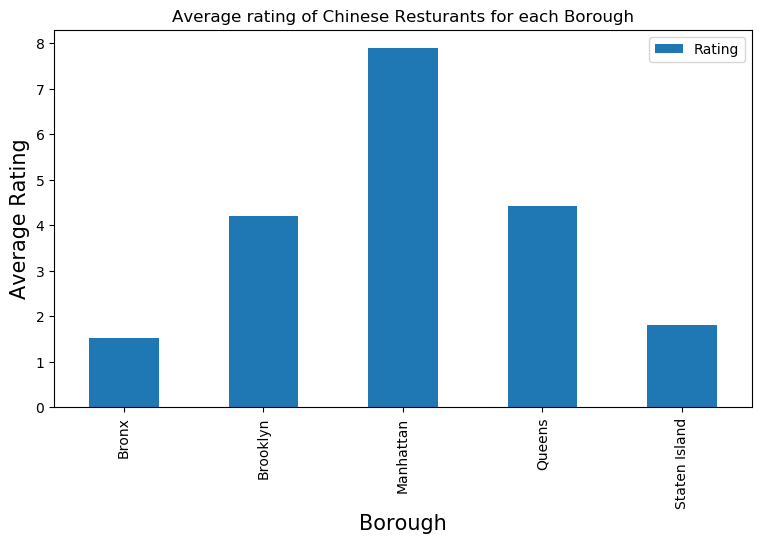

In [40]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Chinese Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
chinese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 9.0 to visualize on map

In [41]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]

In [42]:
ny_neighborhood_stats

,Neighborhood,Average Rating
18,Chelsea,9.2
44,Flatiron,9.2
89,North Side,9.0
129,Windsor Terrace,9.0


We will join this dataset to original new york data to get lonitude and latitude

In [43]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [44]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [45]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Chelsea,40.744035,-74.003116,9.2
1,Staten Island,Chelsea,40.594726,-74.189560,9.2
2,Manhattan,Flatiron,40.739673,-73.990947,9.2
3,Brooklyn,North Side,40.714823,-73.958809,9.0
4,Brooklyn,Windsor Terrace,40.656946,-73.980073,9.0


Now we will show this data on a map

In [46]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [47]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )


Lets add a new field to dataframe for labeling purpose

In [48]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [49]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

Now that we have visualized the Neighborhoods.
<br>Lets Visualize Boroughs based on average Rating

In [ ]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'Borough Boundaries.geojson'

ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

**The saved image can be downloaded at** : https://github.com/chenxixu7/Coursera_Capstone/blob/master/borough_rating.html

### Results 
- Chelsea(Manhattan), North Side(Brooklyn), Flatiron(Manhattan) are some of the best neighborhoods for Chinese cuisine. 
- Even though Chelsea(Staten Island) has a very high average rating, since the Chinese restaurant in Staten Island is very few, this place may not be considered as a good place for Chinese food.
- Staten Island	ranks last in average rating of Chinese Resturants.
- Manhattan, Queens & Brooklyn are all good places for Chinese food. Overall Manhattan has a good balance between restaurant numbers and ratings.

### Conclusion 
In this project we studied the Chinese restaurants in New York City and try to determine which neighborhood is good for having some good Chinese food. We use new york city data and FourSquare API to gather all venues, filtering out Chinese restaurants and then sort the data base on their ratings. Finally we do the data visualization of the average Chinese restaurant ratings for every neighborhoods in New York.